In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
import matplotlib as mpl

%config InlineBackend.figure_format = 'svg'

def score(X, y, model, n=10):
    train_scores = []
    test_scores = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        train_scores.append(train_score)
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)
    return np.mean(train_scores), np.mean(test_scores)

def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s

## Contour plots

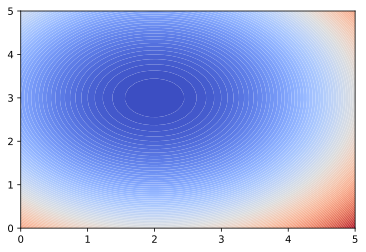

In [11]:
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)

def f(X,Y,c1=2,c2=3): return (X-c1)**2 + (Y-c2)**2
Z = f(X, Y)

plt.contourf(X, Y, Z, levels=100, linewidths=.5, cmap='coolwarm')

In [3]:
def loss(B,X,y):
    "Line coefficients: B = [y-intercept, slope]"
    return np.mean((y - np.dot(X,np.array(B)))**2)
def get_surface(X, y, loss, b1_range, b2_range):
    n = len(X)
    (b1_mesh, b2_mesh) = np.meshgrid(b1_range, b2_range, indexing='ij')
    L = np.zeros(b1_mesh.shape)

    for i in range(len(b1_range)):
        for j in range(len(b2_range)):
            L[i][j] = loss([b1_range[i],b2_range[j]], X=X, y=y)
    return L

In [4]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        X[colname] = (X[colname] - u) / s

## Ames

In [5]:
df_ames = pd.read_csv("../../data/ames.csv")
df_ames['noise'] = np.random.uniform(size=len(df_ames))*10
df_ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,noise
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,0.671909
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,3.822416
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,7.177718
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,6.916951
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,9.737843


In [6]:
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]

# Try with first 3 features
X = df_ames[['2ndFlrSF','FullBath']].copy()#,'FullBath']]LotArea
X = df_ames[['2ndFlrSF','LotArea']].copy()
# X = df_ames[['2ndFlrSF','MSSubClass']].copy()
X = df_ames[['LotArea','noise']].copy()
#X = df_ames[['noise','2ndFlrSF']].copy()
y = df_ames['SalePrice']

In [7]:
#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#y = (y-np.mean(y))
#y = y / np.std(y)
normalize(X)
X.head()

,LotArea,noise
0,-0.207142,-1.527585
1,-0.091886,-0.418120
2,0.073480,0.763465
3,-0.096897,0.671635
4,0.375148,1.665024


True OLS b0 = 180921.20, b_{1..p} = [20954.66568645  -112.23077763]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


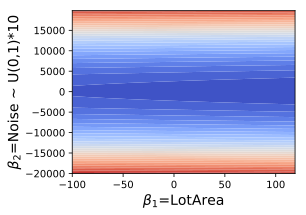

In [8]:
lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-2,2+.1, .1)  # y intercept
b2_range = np.arange(-2,2+.1, .1)     # slope
b1_range = np.arange(-100,120, 1)  # y intercept
b2_range = np.arange(-20000,20000, 200)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$=LotArea', fontsize=14)
ax.set_ylabel('$\\beta_2$=Noise ~ U(0,1)*10', fontsize=14)
# ax.plot([-2,2],[0,0], lw=.5, c='black')
# ax.plot([0,0],[-2,2], lw=.5, c='black')
plt.show()

True OLS b0 = -20165.33, b_{1..p} = [29.05730127 29.05730127]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


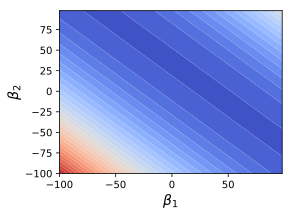

In [28]:
# Try with first 3 features
X = df_ames[['2ndFlrSF','2ndFlrSF']].copy()
y = df_ames['SalePrice']

#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#normalize(X)
y = (y-np.mean(y))

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-8,8, .1)  # y intercept
b2_range = np.arange(-4,4, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=80, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
#surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
cset = ax.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
#ax2.contourf(x, y, z, facecolors=colors)
plt.show()

True OLS b0 = -123305.33, b_{1..p} = [7.47099218e+04 1.83842141e+01]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


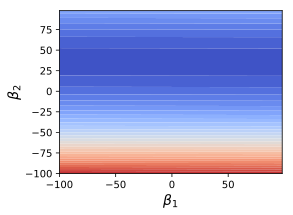

In [22]:
# Try with first 3 features
X = df_ames[['2ndFlrSF','FullBath']].copy()
X = df_ames[['FullBath','2ndFlrSF']].copy()
y = df_ames['SalePrice']

#y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#y = y / np.std(y)
y = (y-np.mean(y))
#normalize(X)

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-4,4, .1)  # y intercept
b2_range = np.arange(-4,4, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
plt.show()

True OLS b0 = -1.73, b_{1..p} = [1.96736379e-05 9.73120598e-01]


/Users/parrt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'offset'
  s)


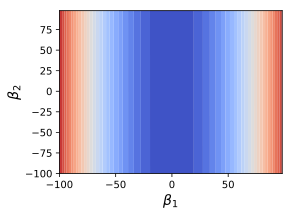

In [23]:
# Try with first 3 features
X = df_ames[['LotArea','FullBath']].copy()#,'FullBath']]LotArea
y = df_ames['SalePrice']

y = (y-np.mean(y)) / np.std(y)  # 0 center y so we can ignore y-intercept; scale down too
#normalize(X)

lm = LinearRegression()
lm.fit(X, y)
true_b0 = lm.intercept_
true_b1 = lm.coef_
print(f"True OLS b0 = {true_b0:.2f}, b_{{1..p}} = {str(true_b1)}")

b1_range = np.arange(-4,4, .1)  # y intercept
b2_range = np.arange(-2, 2, .1)     # slope
b1_range = np.arange(-100,100, 3)  # y intercept
b2_range = np.arange(-100,100, 3)     # slope
L = get_surface(X, y, loss, b1_range=b1_range, b2_range=b2_range)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=45)
b1_range_mesh, b2_range_mesh = np.meshgrid(b1_range, b2_range, indexing='ij')
# surface = ax.plot_surface(b1_range_mesh, b2_range_mesh, L, alpha=0.7, cmap='coolwarm')
cset = plt.contourf(b1_range_mesh, b2_range_mesh, L, offset=0, cmap='coolwarm', levels=30)
ax.set_xlabel('$\\beta_1$', fontsize=14)
ax.set_ylabel('$\\beta_2$', fontsize=14)
plt.show()